In [1]:
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

Deprecation warning: The class RectangularParallelepiped() is deprecated. Please prefer the function capytaine.meshes.predefined.mesh_parallelepiped()


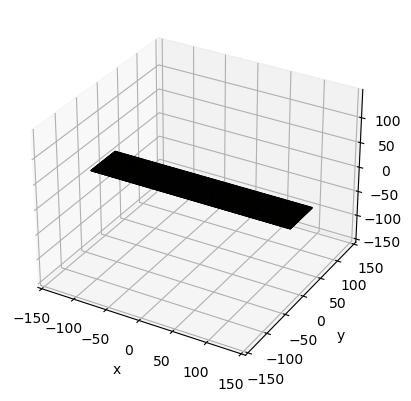

In [2]:
# 单体水动力计算
x = 300
y = 60
z = 2
mesh =3
h = 0.1
m = 300*60*0.9*1025
body = cpt.RectangularParallelepiped(size=(x, y, z), resolution= (int(x/mesh),int(y/mesh),int(z/1)), center=(0, 0, h))
body.center_of_mass = (0,0,h)
body.mass = m
body.add_all_rigid_body_dofs()
body.inertia_matrix = body.compute_rigid_body_inertia()
body.keep_immersed_part(free_surface=0)
body.rotation_center = body.center_of_mass
body.hydrostatic_stiffness = body.compute_hydrostatic_stiffness(rho=1025)
body.name = f"body_{body.mesh.nb_faces:04d}"
body.show_matplotlib()

In [3]:
# omegas = [1.4345, 1.0134, 0.8273, 0.7164, 0.6411, 0.5855, 0.5417, 0.5067, 0.4778, 0.453, 0.4318, 0.4314]
# omegas = np.array(omegas)
# print(omegas)
omegas = np.linspace(0.4314,1.4345,12)
wave_direction = 0
depth = -np.inf
save= False
problems = [cpt.RadiationProblem(body=body, omega=o,rho=1025,sea_bottom=depth,radiating_dof=dof) for dof in body.dofs for o in omegas]
problems += [cpt.DiffractionProblem(omega=o, body=body,rho=1025,wave_direction=wave_direction,sea_bottom=depth) for o in omegas]

bem_solver = cpt.BEMSolver()
# 判断是否使用稀疏矩阵
start_time = time.perf_counter()#运行时间
result = bem_solver.solve_all(problems,n_jobs=15)
dataset = cpt.assemble_dataset(result,wavelength=True) 
print("Dense resolution time: ", time.perf_counter() - start_time, "seconds")
# set beem element stiffness and computing rao
if save == True:
    cpt.io.xarray.separate_complex_values(dataset).to_netcdf(f'BM8_120.nc',
                encoding={'radiating_dof': {'dtype': 'U'},
                            'influenced_dof': {'dtype': 'U'}})

Dense resolution time:  10.124503599999997 seconds


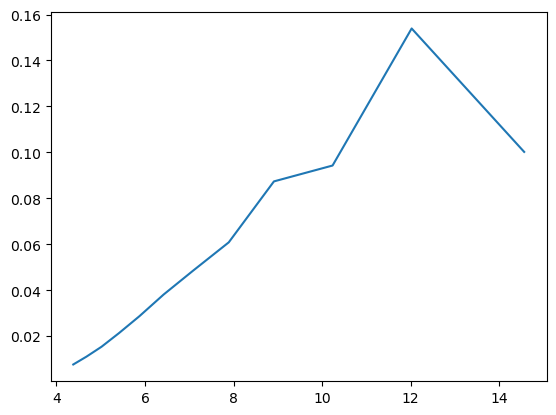

In [4]:
from capytaine.post_pro import rao
dataset['rao'] = rao(dataset, wave_direction=0, dissipation=None, stiffness=None)
plt.plot(2*np.pi/omegas,abs(dataset['rao'].sel(radiating_dof='Heave')))

In [8]:
import DM_Windload as DM_Wind
windload_cd = DM_Wind.WindLoad(U10=14.3, z=3, total_rows=31, total_cols=151, file_path="E:\phd\Code\DM-FEM2D\winddata\Ti0.1_cd_degree0.txt")
windload_cl = DM_Wind.WindLoad(U10=14.3, z=3, total_rows=31, total_cols=151, file_path="E:\phd\Code\DM-FEM2D\winddata\Ti0.1_cl_degree0.txt")
# represent wind frequency 0.01, dof represent the position of force
# Wind_Force = windload_cd.compute_wind_force(0.01, dof=0) + windload_cl.compute_wind_force(0.01, dof=2)
Wind_Damping = windload_cd.compute_wind_damping(dof=0) + windload_cl.compute_wind_damping(dof=2) + windload_cd.compute_wind_damping(dof=4)*1

vvv = Wind_Damping.reshape(31*151,6)
result_matrix = np.sum(vvv, axis=0, keepdims=True)
damping = np.diag(result_matrix[0])
# # 将 omegas 扩展为 (30, 1) 的形状，然后进行广播操作
# omegas_broadcasted = omegas[:, np.newaxis]
# result_matrix = omegas_broadcasted * damping
damping = np.tile(damping, (12, 1, 1))
# import xarray as xr
# damping = xr.DataArray(damping)
type(damping)

numpy.ndarray

In [5]:
# omegas_broadcasted = omegas[:, np.newaxis, np.newaxis]
# result_matrix = omegas_broadcasted * damping

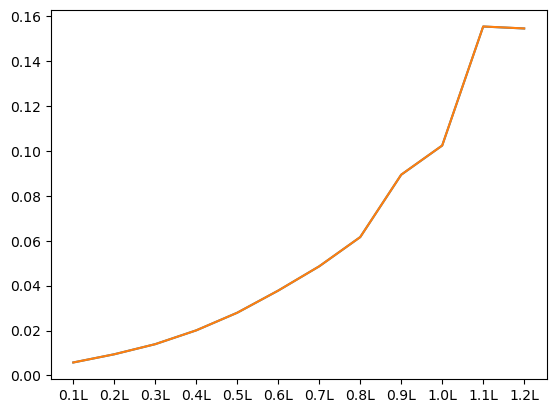

In [12]:
from capytaine.post_pro import rao
dataset['rao'] = rao(dataset, wave_direction=0, dissipation=None, stiffness=None)
dataset['radiation_damping'].values = dataset['radiation_damping'] + damping
dataset['rao1'] = rao(dataset, wave_direction=0, dissipation=None, stiffness=None)
x_label = ['0.1L','0.2L','0.3L','0.4L','0.5L','0.6L','0.7L','0.8L','0.9L','1.0L','1.1L','1.2L']
plt.plot(x_label,abs(dataset['rao'].sel(radiating_dof='Heave')[::-1]))
plt.plot(x_label,abs(dataset['rao1'].sel(radiating_dof='Heave')[::-1]))

In [10]:
dataset[]

<xarray.Dataset>
Dimensions:                (omega: 12, radiating_dof: 6, influenced_dof: 6,
                            wave_direction: 1)
Coordinates:
    g                      float64 9.81
    rho                    int64 1025
    body_name              <U9 'body_2240'
    water_depth            float64 inf
  * omega                  (omega) float64 0.4314 0.5226 0.6138 ... 1.343 1.435
  * radiating_dof          (radiating_dof) object 'Surge' 'Sway' ... 'Yaw'
  * influenced_dof         (influenced_dof) object 'Surge' 'Sway' ... 'Yaw'
  * wave_direction         (wave_direction) float64 0.0
    wavelength             (omega) float64 331.2 225.7 163.6 ... 34.16 29.95
Data variables:
    added_mass             (omega, radiating_dof, influenced_dof) float64 2.8...
    radiation_damping      (omega, radiating_dof, influenced_dof) float64 3.5...
    diffraction_force      (omega, wave_direction, influenced_dof) complex128 ...
    Froude_Krylov_force    (omega, wave_direction, influenced_dof) complex128 ...
    inertia_matrix         (influenced_dof, radiating_dof) float64 1.660e+07 ...
    hydrostatic_stiffness  (influenced_dof, radiating_dof) float64 0.0 ... 0.0
    excitation_force       (omega, wave_direction, influenced_dof) complex128 ...
    rao                    (omega, radiating_dof) complex128 (-0.037680140771...
    rao1                   (omega, radiating_dof) complex128 (-0.037341737798...
Attributes:
    creation_of_dataset:        2023-09-19T20:14:38.557962
    incoming_waves_convention:  nemoh
    capytaine_version:          1.5

In [48]:
x1 = dataset['rao'].values[-4][2]
x2 = dataset['rao'].values[-4][4]
X = np.linspace(-150,150,300)

In [45]:
abs(x1)

0.02009906283061082

In [49]:

z = x1+x2*X

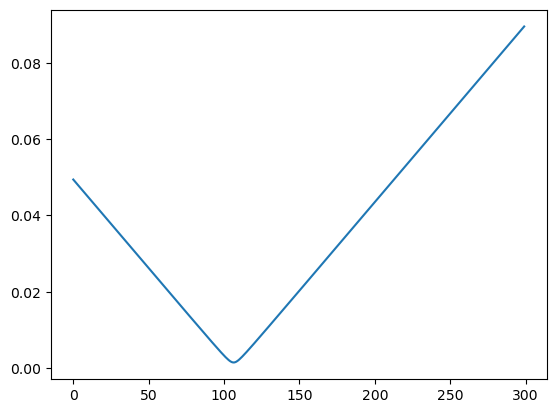

In [50]:
plt.plot(abs(z))

In [36]:
len(z)

301